(gravity-code)=

# Joint cross-gradient inversion (Open-source version)

```{figure} ../images/landing.png
---
scale: 30%
align: right
---
```

This section demonstrates the joint inversion of gravity and magnetic data.

For an equivalent and streamlined version of this tutorial, see the parent [Forrestania](forrestania) case study.

```{note}
The steps taken in this tutorial are strongly based on the official [SimPEG Tutorials](https://simpeg.xyz/user-tutorials/).
```

In [1]:
# Import necessary Python libraries for data handling and visualization
import os
import zipfile
from pathlib import Path
from tempfile import mkdtemp

import discretize
import matplotlib.pyplot as plt
import numpy as np
import pandas
import scipy as sp
import simpeg
from geoh5py import Workspace, objects
from PIL import Image

# Import SimPEG library
from simpeg import (
    dask,  # Parallel version of the code
    maps,
    potential_fields,
)

# Mira Geoscience specific libraries
from simpeg_drivers import assets_path

## Geological setting

See the [Forrestania-Geology](forrestania-geology) section for more background information.

## Data Preparation

We load the data directly from numpy arrays.

Readers are invited to read the processing steps performed in the 
[Gravity](gravity-code) and [Magnetics](magnetics-code) notebooks.

The zipped package contains the following three files:
 - Ground gravity survey: `Forrestania_Gravity_Station_trim_.csv`
 - Digital Elevation Model (DEM): `Forrestania_SRTM1 Australia_MGA50.tiff`

In [2]:
grav_array = np.load(assets_path() / r"Case studies/gravity.npy")
mag_array = np.load(assets_path() / r"Case studies/magnetic.npy")
dem = np.load(assets_path() / r"Case studies/dem.npy")

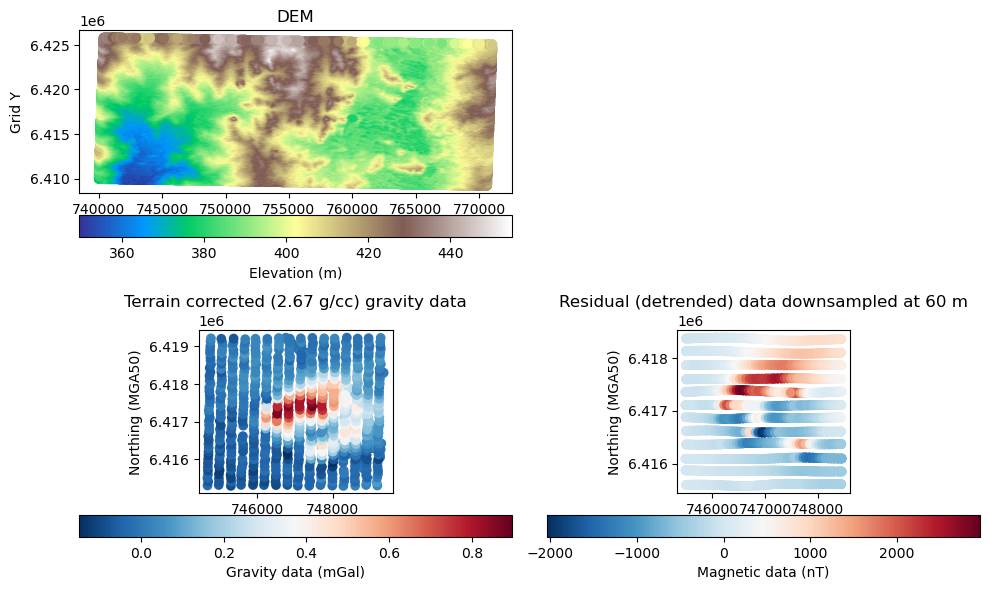

In [3]:
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(2, 2, 1)
im = ax.scatter(dem[:, 0], dem[:, 1], c=dem[:, 2], cmap="terrain")
cbar = plt.colorbar(im, orientation="horizontal", pad=0.1)
cbar.set_label("Elevation (m)")
ax.set_title("DEM")
ax.set_xlabel("Grid X")
ax.set_ylabel("Grid Y")
plt.tight_layout()

ax = plt.subplot(2, 2, 3)
im = ax.scatter(grav_array[:, 0], grav_array[:, 1], c=grav_array[:, 3], cmap="RdBu_r")
cbar = plt.colorbar(im, orientation="horizontal", pad=0.1)
cbar.set_label("Gravity data (mGal)")
ax.set_aspect("equal")
ax.set_title("Terrain corrected (2.67 g/cc) gravity data")
ax.set_xlabel("Easting (MGA50)")
ax.set_ylabel("Northing (MGA50)")
plt.tight_layout()

ax = plt.subplot(2, 2, 4)
im = ax.scatter(mag_array[:, 0], mag_array[:, 1], c=mag_array[:, 3], cmap="RdBu_r")
cbar = plt.colorbar(im, orientation="horizontal", pad=0.1)
cbar.set_label("Magnetic data (nT)")
ax.set_aspect("equal")
ax.set_title("Residual (detrended) data downsampled at 60 m")
ax.set_xlabel("Easting (MGA50)")
ax.set_ylabel("Northing (MGA50)")
plt.tight_layout()

plt.show()

(forrestania-gravity-inv)=
## Inversion

We proceed with the inversion of both datasets jointly. Our goal is to model the shape and position of geological units in 3D based on correlated density and magnetic contrasts.

### Create meshes

We need to break down the subsurface into a grid of cells under the following considerations: use the least number of cells to remain computationally efficient while having enough resolution to model small features accurately. We can achieve both goals with an octree mesh. 

In [4]:
# Determine the smallest cell size, half the flight height and data resolution
base_cells = [30, 30, 30]
all_locs = np.vstack([grav_array[:, :3], mag_array[:, :3]])
# Create the base TreeMesh grid (without refinement)
octree = discretize.utils.mesh_builder_xyz(
    all_locs,  # Keep the same extent towards the joint
    base_cells,
    mesh_type="tree",
    depth_core=2000,  # At least as deep as 2000 m
)


# Refine around each receiver location
octree.refine_points(
    all_locs,
    level=-1,  # Use the (last) highest level
    padding_cells_by_level=[6, 6, 6],  # Number of cells at 30 m, 60 m and 120 m
    finalize=False,
)

# Refine along topography
octree.refine_surface(
    dem,
    level=-3,  # Only refine at 120 m on dem
    padding_cells_by_level=[1],
    finalize=True,  # Complete the mesh on our last call
)

### Defining the air-ground domains

We need to tell the inversion what part of the octree grid lies below the surface. 

In [5]:
active = discretize.utils.active_from_xyz(octree, dem)
n_actives = int(active.sum())
print(f"Number of active cells: {n_actives}")

Number of active cells: 242855


### Survey and Simulation

We now define the "geophysical" experiment in terms of survey configurations, and tell SimPEG how to simulate data. 

In [6]:
# Define wire maps to associate the correct slice of model values to each simulation.
proj_grav = maps.Projection(2 * n_actives, slice(0, n_actives))
proj_mag = maps.Projection(2 * n_actives, slice(n_actives, 2 * n_actives))

# Create a gravity survey
receiver_list = potential_fields.gravity.receivers.Point(
    grav_array[:, :3], components=["gz"]
)

# Define the inducing field parameter ("the source")
source_field = potential_fields.gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
grav_survey = potential_fields.gravity.survey.Survey(source_field)

# Put it all together
simulation = potential_fields.gravity.simulation.Simulation3DIntegral(
    survey=grav_survey,
    mesh=octree,
    active_cells=active,
    rhoMap=simpeg.maps.IdentityMap(nP=n_actives),
)

grav_simulation = simpeg.meta.MetaSimulation(
    simulations=[simulation], mappings=[proj_grav]
)

# Create a magnetic survey
receiver_list = potential_fields.magnetics.receivers.Point(
    mag_array[:, :3], components=["tmi"]
)

# Define the inducing field parameter ("the source")
source_field = potential_fields.magnetics.sources.UniformBackgroundField(
    receiver_list=receiver_list,
    amplitude=59294,
    inclination=-67.1,
    declination=-0.89,
)

# Define the survey
mag_survey = potential_fields.magnetics.survey.Survey(source_field)

# Put it all together
simulation = potential_fields.magnetics.simulation.Simulation3DIntegral(
    survey=mag_survey,
    mesh=octree,
    active_cells=active,
    chiMap=simpeg.maps.IdentityMap(nP=n_actives),
)
mag_simulation = simpeg.meta.MetaSimulation(
    simulations=[simulation], mappings=[proj_mag]
)

### Data misfit functions

One of the main requirements for the inversion is to find a model that replicates the observed data. We enforce that constraint with a least-square measure of data fit.

In [7]:
# Create a gravity Data class that contains everything
data = simpeg.Data(
    grav_survey,
    dobs=grav_array[:, -1],
    standard_deviation=0.025,  # Assign the data uncertainty to a quarter of the standard deviation
)
grav_misfit = simpeg.data_misfit.L2DataMisfit(data=data, simulation=grav_simulation)
grav_misfit.name = "grav"

# Create a magnetic Data class that contains everything
data = simpeg.Data(
    mag_survey,
    dobs=mag_array[:, -1],
    standard_deviation=150,  # Assign the data uncertainty to a quarter of the standard deviation
)
mag_misfit = simpeg.data_misfit.L2DataMisfit(data=data, simulation=mag_simulation)
mag_misfit.name = "mag"

data_misfit = grav_misfit + mag_misfit

### Regularization function

In order to constrain the model, we need to add a `regularization` function. We will use multiple functions to constrain indivudal physical properties, as well as the cross-gradient term.

In [8]:
# Regularize the density model
den_reg = simpeg.regularization.Sparse(
    octree,
    active_cells=active,
    reference_model=np.zeros(2 * n_actives),
    norms=[0, 1, 1, 1],
    mapping=proj_grav,
)

# Regularize the mag model
mag_reg = simpeg.regularization.Sparse(
    octree,
    active_cells=active,
    reference_model=np.zeros(2 * n_actives),
    norms=[0, 1, 1, 1],
    mapping=proj_mag,
)

# Cross-gradient (coupling) constraint
wires = maps.Wires(
    ("density", proj_grav),
    ("susceptibility", proj_mag),
)

coupling = simpeg.regularization.CrossGradient(
    octree,
    wires,
    active_cells=active,
)

regularization = den_reg + mag_reg + coupling

# Scale the coupling term
regularization.multipliers = [1, 1, 30.0**4]

### Inversion directives

We want to control the different steps of the inversions, such as:
 - Initial trade-off parameter
 - Cooling schedule for data fit
 - Sparsity promoting iterations and target

This is done through `Directives`.

In [9]:
sensitivity_weights = simpeg.directives.UpdateSensitivityWeights(every_iteration=False)
starting_beta = simpeg.directives.BetaEstimate_ByEig(beta0_ratio=10)
update_jacobi = simpeg.directives.UpdatePreconditioner(update_every_iteration=True)
update_irls = simpeg.directives.UpdateIRLS(max_irls_iterations=15)
scale_misfits = simpeg.directives.ScaleMisfitMultipliers(
    Path("./")
)  # Make sure that all misfits converge together
directives_list = [
    update_irls,
    scale_misfits,
    sensitivity_weights,
    starting_beta,
    update_jacobi,
]

### Inverse problem

In [10]:
# Define the optimization strategy
optimizer = simpeg.optimization.ProjectedGNCG(
    maxIter=40, lower=np.r_[-np.ones(n_actives), np.zeros(n_actives)], maxIterLS=2
)

# Define an inverse problem, the inversion and run
inv_problem = simpeg.inverse_problem.BaseInvProblem(
    data_misfit, regularization, optimizer
)
inversion = simpeg.inversion.BaseInversion(inv_problem, directives_list)

# Create a simple starting model
m_start = np.ones(2 * n_actives) * 1e-4
rec_model = inversion.run(m_start)


Running inversion with SimPEG v0.22.2.dev43+gcd269b4c1.d20241026
simpeg.InvProblem will set Regularization.reference_model to m0.
[########################################] | 100% Completed | 8.28 ss
[########################################] | 100% Completed | 73.44 s
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.31e+01  1.59e+05  4.01e+00  1.60e+05    2.58e+04      0              
   1  3.66e+01  1.29e+05  1.48e+02  1.34e+05    1.44e+04      0              
   2  1.83e+01  1.17e+05  3.75e+02  1.24e+05    8.24e+03      0   Skip BFGS  
   3  9.14e+00  1.06e+05  8.18e+02  1.13e+05    8.01e+03      0   Skip BFGS  
   4  4.57e+00  9.31e+04  1.74e+03  1.01e+05    8.12e+03      0   Skip BFGS  
   5  2.28e+00  7.84e+04  3.64e+03  8.68e+04    7.88e+03      0  

## Results

### Data fit

Validating the data fit is a critical step before starting any interpratation. Without a good data fit, nothing conclusive can be said about the 3D density model. We want to make sure that most of the signal is captured, leaving only behind random noise (residuals).

Text(0.5, 1.0, 'Residual')

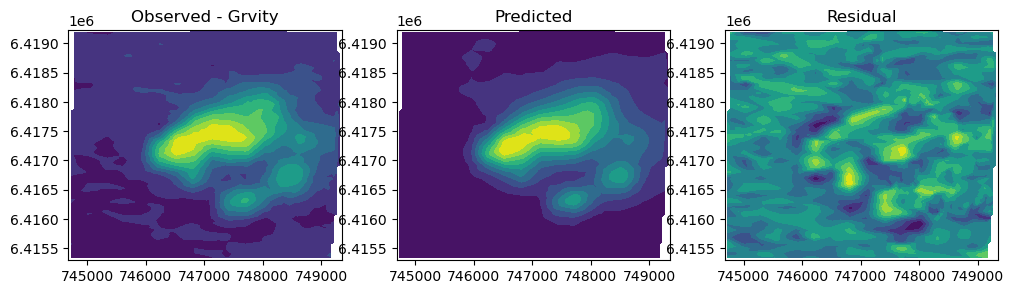

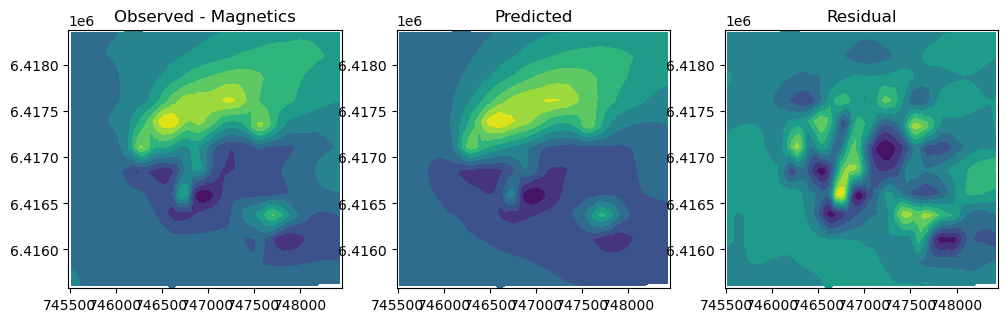

In [11]:
# Validate observed versus predicted
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 3, 1)
simpeg.utils.plot_utils.plot2Ddata(grav_array[:, :2], grav_array[:, -1], ax=ax)
ax.set_title("Observed - Grvity")

ax = plt.subplot(1, 3, 2)
simpeg.utils.plot_utils.plot2Ddata(grav_array[:, :2], inv_problem.dpred[0], ax=ax)
ax.set_title("Predicted")

ax = plt.subplot(1, 3, 3)
simpeg.utils.plot_utils.plot2Ddata(
    grav_array[:, :2], grav_array[:, -1] - inv_problem.dpred[0], ax=ax
)
ax.set_title("Residual")


fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 3, 1)
simpeg.utils.plot_utils.plot2Ddata(mag_array[:, :2], mag_array[:, -1], ax=ax)
ax.set_title("Observed - Magnetics")

ax = plt.subplot(1, 3, 2)
simpeg.utils.plot_utils.plot2Ddata(mag_array[:, :2], inv_problem.dpred[1], ax=ax)
ax.set_title("Predicted")

ax = plt.subplot(1, 3, 3)
simpeg.utils.plot_utils.plot2Ddata(
    mag_array[:, :2], mag_array[:, -1] - inv_problem.dpred[1], ax=ax
)
ax.set_title("Residual")

While there might still be some correlated signal in the residuals, overall the data fit is good. 
We can move on to interpretating the model.

### Models

The inversion took 13 iterations to reach the target misfit, followed by 12 iterations to increase sparsity. The figure below shows horizontal and vertical sections through both solutions. 

See the [Regularization Section](regularization) for more details on sparsity constraints.

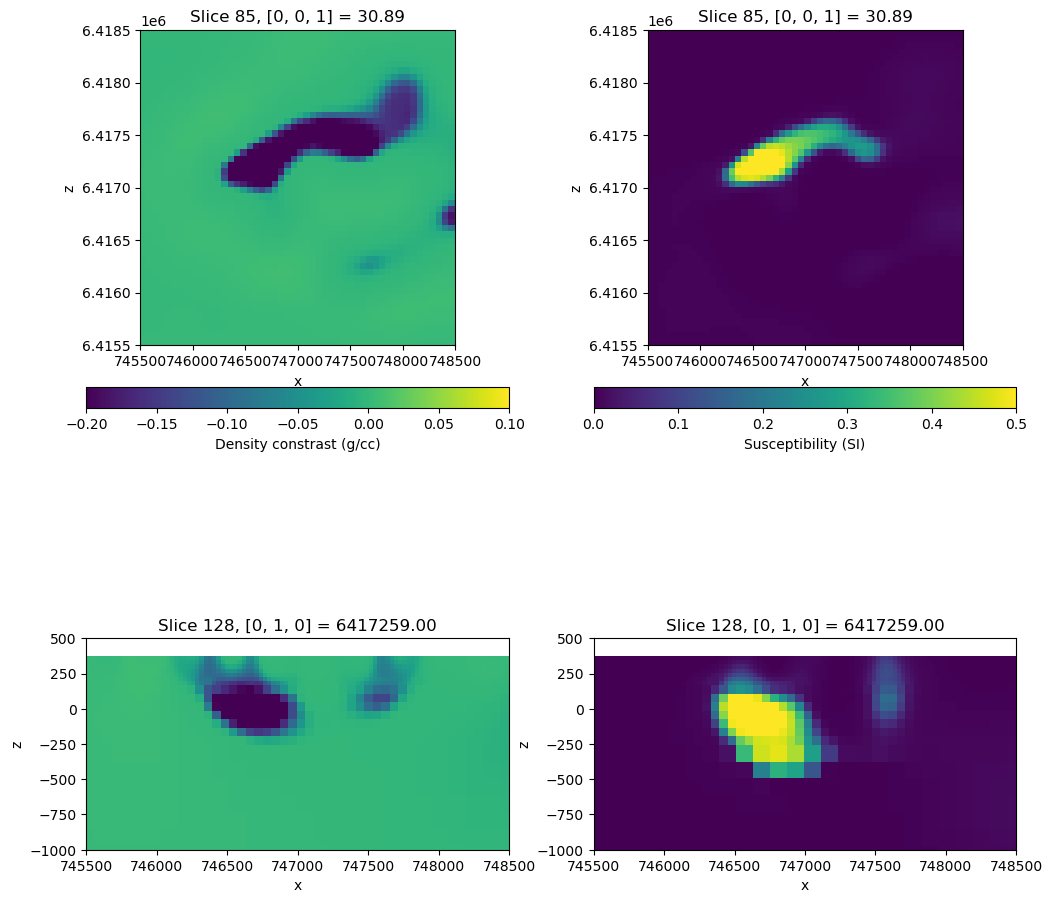

In [12]:
# Mapping to ignore inactive cells when plotting
plotting_map = simpeg.maps.InjectActiveCells(octree, active, np.nan)

fig = plt.figure(figsize=(12, 12))

ax = plt.subplot(2, 2, 1)
im = octree.plot_slice(
    plotting_map * proj_grav * rec_model, normal="Z", ind=85, ax=ax, clim=[-0.2, 0.1]
)
ax.set_xlim([745500, 748500])
ax.set_ylim([6415500, 6418500])
ax.set_aspect(1)
cbar = plt.colorbar(im[0], orientation="horizontal", pad=0.1)
cbar.set_label("Density constrast (g/cc)")

ax = plt.subplot(2, 2, 3)
im = octree.plot_slice(
    plotting_map * proj_grav * rec_model, normal="Y", ax=ax, clim=[-0.2, 0.1]
)
ax.set_aspect(1)
ax.set_xlim([745500, 748500])
ax.set_ylim([-1000, 500])
ax.set_aspect(1)


ax = plt.subplot(2, 2, 2)
im = octree.plot_slice(
    plotting_map * proj_mag * rec_model, normal="Z", ind=85, ax=ax, clim=[0, 0.5]
)
ax.set_xlim([745500, 748500])
ax.set_ylim([6415500, 6418500])
ax.set_aspect(1)
cbar = plt.colorbar(im[0], orientation="horizontal", pad=0.1)
cbar.set_label("Susceptibility (SI)")

ax = plt.subplot(2, 2, 4)
im = octree.plot_slice(
    plotting_map * proj_mag * rec_model, normal="Y", ax=ax, clim=[0, 0.5]
)
ax.set_aspect(1)
ax.set_xlim([745500, 748500])
ax.set_ylim([-1000, 500])
ax.set_aspect(1)

Readers can compare these results with the models obtained in the standalone [gravity](gravity-code) and [magnetics](magnetics-code) inversions.

We note the following:

 - Compared to the standalone inversions, we recover similar edges in the density and magnetic susceptibility.
 - In plan view, the density anomaly extends further to the North-East, indicative of either alteration or a change in geology.